In [1]:
import os
import glob
import sys
import h5py
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
from torch.autograd import Variable
import torch
import functools
import operator
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
pwd

'/home/pc19d/hw8'

In [3]:
source_folder = "//home//pc19d//hw8"

In [4]:
os.listdir(source_folder)

['cnntrain.zip',
 '.ipynb_checkpoints',
 'cnntest',
 'model',
 'hw8_cuda_pankaj.ipynb',
 'cnntrain',
 'cnntest.zip',
 'Untitled.ipynb']

In [5]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self,folder,train):
        super(MyDataset, self).__init__()
        self.train = train
        self.folder = folder
        self.label_mean = 52.90
        if self.train:
            self.root = os.path.join(self.folder,"cnntrain")
        else:
            self.root = os.path.join(self.folder,"cnntest")
        self.files = os.listdir(self.root) # take all files in the root directory
    
    
    def __len__(self):
        return len(self.files)
   
    def __getitem__(self, idx):
        #sample, label = torch.load(os.path.join(self.root, self.files[idx])) # load the features of this sample
        sample = plt.imread(os.path.join(self.root, self.files[idx]))
        sample = np.moveaxis(sample,-1,0)
        label  = np.array(float((self.files[idx][-20:-18]))-self.label_mean).astype(float)
        #print(label)
        sample,label = torch.from_numpy(sample).type(torch.FloatTensor),torch.from_numpy(label).type(torch.FloatTensor)
        #label = label.view(-1,1)
        return sample, label

In [6]:
class CNN(nn.Module):
    r"""Implements the middel part of the FFDNet architecture, which
    is basically a DnCNN net
    """
    def __init__(self,in_channels, out_channels, input_dim):
        super(CNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=5,padding=1,bias=False,dilation=2))
        
        for _ in range(1):
            layers.append(nn.Conv2d(in_channels=32,\
                                    out_channels=32,\
                                    kernel_size=5,\
                                    padding=1,\
                                    bias=False,dilation=2))
            layers.append(nn.BatchNorm2d(32))
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.Conv2d(in_channels=32,out_channels=16,kernel_size=5,padding=1,bias=False,dilation=2))
        layers.append(nn.BatchNorm2d(16))
        layers.append(nn.MaxPool2d(2,2))
        layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.Conv2d(in_channels=16,out_channels=8,kernel_size=2,padding=1,bias=False,dilation=2))
        layers.append(nn.BatchNorm2d(8))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(2,2))
            
        self.feature_extractor = nn.Sequential(*layers)
        
        
        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=10),
            nn.Linear(in_features=10, out_features=out_channels),
        )
        
    def forward(self, x):
        out = self.feature_extractor(x)
        out = out.view(x.size(0), -1)  # flatten the vector
        out = self.classifier(out)
        return out

In [7]:
def main():
    
    #train_data =  np.moveaxis(train_data,-1,1)
    #test_data  =  np.moveaxis(test_data,-1,1)
    #N_train,N_test  = train_data.shape[0],test_data.shape[0]
    
    #print(train_data.shape,test_data.shape)
    
    #dataset_train = TensorDataset( Tensor(train_data), Tensor(train_label))
    #dataset_val   = TensorDataset( Tensor(test_data), Tensor(test_label))
    
    source_folder = "//home//pc19d//hw8"
    dataset_train = MyDataset(folder=source_folder,train=True)
    dataset_val   = MyDataset(folder=source_folder,train=False)
    N_train = 18059
    N_test = 2261
    
    # defining the model
    input_dim = (3,64,64)
    model = CNN(3,1,input_dim)

    # Define loss
    criterion = nn.MSELoss(reduction='sum')
    
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9,weight_decay = 0.0001)
    
    
    # Move to GPU
    device_ids = [0]
    model.to(device)
    criterion.to(device)

    
    test_loss  = []
    train_loss = []
    
    R2_test  = []
    R2_train = []
    
    
    for epoch in range(100): 
        
        batch_size = 0
        if epoch <= 20:
            batch_size = 32
        elif epoch > 20 and epoch <= 40:
            batch_size = 64
        elif epoch > 40 and epoch <= 60:
            batch_size = 128          
        elif epoch > 60 and epoch <= 80:
            batch_size = 256
        else:
            batch_size = 512
        
        if epoch in list([0,21,41,61,81]):
            loader_train  = DataLoader(dataset=dataset_train, batch_size = batch_size)
            loader_test   = DataLoader(dataset=dataset_val,batch_size = batch_size)
            
        running_train_loss = 0
        running_test_loss  = 0
        predictions_train, actuals_train = list(), list()
        
        
        for data,label in loader_train:
            
            #print(data.shape,label.shape)
            # Pre-training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            
            img_train = Variable(data.to(device))
            label     = Variable(label.to(device))
            out_train = model(img_train)
            #print(label.size(),out_train.size())
            label = label.unsqueeze(1)
            
            #print(label.size(),out_train.size())
            #sys.exit()
            loss = criterion(out_train, label)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            
            model.eval()
            with torch.no_grad():
                y_predicted_train_batch = model(img_train)
                actual = label.cpu().numpy() #In case if there's shuffling of data
                actual = actual.reshape((len(actual), 1))
                # round to class values
                #y_predicted_train_batch = y_predicted_train_batch.round()
                # store
                
                for element in y_predicted_train_batch:
                    predictions_train.append(element)
                for element in actual:
                    actuals_train.append(element)
                    
                #pint(np.array(predictions_train).shape,np.array(actuals_train).shape)
            
            model.train()
            
            #print(loss.item())

        train_loss.append(running_train_loss/N_train)
        actuals_train,predictions_train = np.array(actuals_train).flatten(),np.array(predictions_train).flatten()
        
        #print(actuals_train.shape,predictions_train.shape)
        y_bar_train = np.mean(actuals_train)
        
        assert actuals_train.shape ==  predictions_train.shape
        
        R2_train.append(1 - np.sum(np.square(actuals_train -  predictions_train)) / np.sum(np.square(actuals_train -  y_bar_train)))
    
        model.eval()
        predictions_test, actuals_test = list(), list()
        
        with torch.no_grad():
            for inputs, labels in loader_test:
                
                y_predicted_on_current_batch = model(inputs.to(device))
                labels = labels.to(device)
                labels = labels.unsqueeze(1)
                
                #print(labels.size(),y_predicted_on_current_batch.size())
                #sys.exit()
                batch_loss = criterion(y_predicted_on_current_batch, labels)
                running_test_loss += batch_loss.item()

                actual = labels.cpu().numpy() #In case if there's shuffling of data
                actual = actual.reshape((len(actual), 1))
                # round to class values
                #y_predicted_on_current_batch = y_predicted_on_current_batch.round()
                # store
                
                for element in y_predicted_on_current_batch:
                    predictions_test.append(element)
                for element in actual:
                    actuals_test.append(element)
 
        
    
        test_loss.append(running_test_loss/N_test)
        actuals_test,predictions_test = np.array(actuals_test).flatten(),np.array(predictions_test).flatten()
        #print(actuals_test.shape,predictions_test.shape)
        assert actuals_test.shape ==  predictions_test.shape
        
        #y_bar_test  = np.mean(actuals_test)
        R2_test.append(1 - np.sum(np.square(actuals_test -  predictions_test)) / np.sum(np.square(actuals_test -  y_bar_train)))
        
        model.train()
        print(R2_test[-1],R2_train[-1],test_loss[-1],train_loss[-1])
        
    torch.save(model.state_dict(), os.path.join(source_folder,"model","NetA.pt"))
    return R2_test,R2_train,test_loss,train_loss

In [8]:
R2_test,R2_train,test_loss,train_loss = main()

/home/pc19d/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)


tensor([0.8289], device='cuda:0') tensor([0.5511], device='cuda:0') 129.87273449161736 182.20020164617753
tensor([0.8732], device='cuda:0') tensor([0.8440], device='cuda:0') 96.21707891627045 83.26335977408252
tensor([0.8926], device='cuda:0') tensor([0.8624], device='cuda:0') 81.47599668979434 71.21286894719435
tensor([0.8639], device='cuda:0') tensor([0.8758], device='cuda:0') 103.2694655987395 64.92997729447575
tensor([0.8568], device='cuda:0') tensor([0.8847], device='cuda:0') 108.63475093984962 60.42032896756162
tensor([0.8774], device='cuda:0') tensor([0.8892], device='cuda:0') 93.0333740018417 57.03695409174767
tensor([0.8813], device='cuda:0') tensor([0.8933], device='cuda:0') 90.08282921515645 54.18972374438527
tensor([0.8679], device='cuda:0') tensor([0.8984], device='cuda:0') 100.22020361392913 51.79184805070901
tensor([0.8748], device='cuda:0') tensor([0.9012], device='cuda:0') 94.97635669193664 49.72571679012899
tensor([0.8700], device='cuda:0') tensor([0.9057], device='cu

tensor([0.8809], device='cuda:0') tensor([0.9167], device='cuda:0') 90.35832112450244 25.157276704677205
tensor([0.8594], device='cuda:0') tensor([0.9011], device='cuda:0') 106.67695347053295 27.16074793850625
tensor([0.7988], device='cuda:0') tensor([0.7252], device='cuda:0') 152.67299970975233 43.44127798120051
tensor([0.8575], device='cuda:0') tensor([0.9090], device='cuda:0') 108.1219834973463 33.52655826583179
tensor([0.8873], device='cuda:0') tensor([0.9412], device='cuda:0') 85.52875525210084 26.299458653752975
tensor([0.8605], device='cuda:0') tensor([0.9353], device='cuda:0') 105.87906692282176 24.555142713640013
tensor([0.8778], device='cuda:0') tensor([0.9378], device='cuda:0') 92.72666184072312 27.045481171849044
tensor([0.8475], device='cuda:0') tensor([0.9098], device='cuda:0') 115.72426816121185 31.26211188413672
tensor([0.8369], device='cuda:0') tensor([0.9188], device='cuda:0') 123.7362417417625 34.55188572980404
tensor([0.8962], device='cuda:0') tensor([0.9284], devic

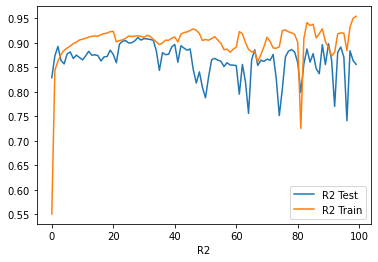

In [18]:
plt.plot(R2_test,label ="R2 Test")
plt.plot(R2_train,label="R2 Train")
plt.xlabel('Epoch')
plt.xlabel('R2')
plt.legend()

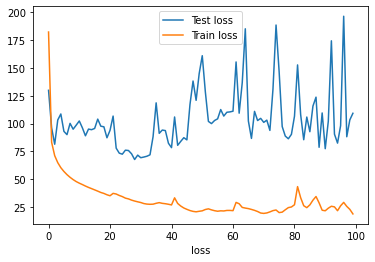

In [19]:
plt.plot(test_loss,label ="Test loss")
plt.plot(train_loss,label="Train loss")
plt.xlabel('Epoch')
plt.xlabel('loss')
plt.legend()

## Part B

In [9]:
def main2():
    
    source_folder = "//home//pc19d//hw8"
    dataset_train = MyDataset(folder=source_folder,train=True)
    dataset_val   = MyDataset(folder=source_folder,train=False)
    loader_train  = DataLoader(dataset=dataset_train, batch_size = 512)
    loader_test   = DataLoader(dataset=dataset_val,batch_size = 512)
    
    N_train = 18059
    N_test = 2261
    
    # defining the model
    input_dim = (3,64,64)
    model = CNN(3,1,input_dim)

    # Define loss
    criterion = nn.MSELoss(reduction='sum')
    
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9,weight_decay = 0.0001)
    
    
    # Move to GPU
    device_ids = [0]
    model.to(device)
    criterion.to(device)

    
    test_loss  = []
    train_loss = []
    
    R2_test  = []
    R2_train = []
    
    
    for epoch in range(100): 
              
        running_train_loss = 0
        running_test_loss  = 0
        predictions_train, actuals_train = list(), list()
        
        
        for data,label in loader_train:
            
            #print(data.shape,label.shape)
            # Pre-training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            
            img_train = Variable(data.to(device))
            label     = Variable(label.to(device))
            out_train = model(img_train)
            #print(label.size(),out_train.size())
            label = label.unsqueeze(1)
            
            #print(label.size(),out_train.size())
            #sys.exit()
            loss = criterion(out_train, label)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            
            model.eval()
            with torch.no_grad():
                y_predicted_train_batch = model(img_train)
                actual = label.cpu().numpy() #In case if there's shuffling of data
                actual = actual.reshape((len(actual), 1))
                # round to class values
                #y_predicted_train_batch = y_predicted_train_batch.round()
                # store
                
                for element in y_predicted_train_batch:
                    predictions_train.append(element)
                for element in actual:
                    actuals_train.append(element)
                    
                #pint(np.array(predictions_train).shape,np.array(actuals_train).shape)
            
            model.train()
            
            #print(loss.item())

        train_loss.append(running_train_loss/N_train)
        actuals_train,predictions_train = np.array(actuals_train).flatten(),np.array(predictions_train).flatten()
        
        #print(actuals_train.shape,predictions_train.shape)
        y_bar_train = np.mean(actuals_train)
        
        assert actuals_train.shape ==  predictions_train.shape
        
        R2_train.append(1 - np.sum(np.square(actuals_train -  predictions_train)) / np.sum(np.square(actuals_train -  y_bar_train)))
    
        model.eval()
        predictions_test, actuals_test = list(), list()
        
        with torch.no_grad():
            for inputs, labels in loader_test:
                
                y_predicted_on_current_batch = model(inputs.to(device))
                labels = labels.to(device)
                labels = labels.unsqueeze(1)
                
                #print(labels.size(),y_predicted_on_current_batch.size())
                #sys.exit()
                batch_loss = criterion(y_predicted_on_current_batch, labels)
                running_test_loss += batch_loss.item()

                actual = labels.cpu().numpy() #In case if there's shuffling of data
                actual = actual.reshape((len(actual), 1))
                # round to class values
                #y_predicted_on_current_batch = y_predicted_on_current_batch.round()
                # store
                
                for element in y_predicted_on_current_batch:
                    predictions_test.append(element)
                for element in actual:
                    actuals_test.append(element)
 
        
    
        test_loss.append(running_test_loss/N_test)
        actuals_test,predictions_test = np.array(actuals_test).flatten(),np.array(predictions_test).flatten()
        #print(actuals_test.shape,predictions_test.shape)
        assert actuals_test.shape ==  predictions_test.shape
        
        #y_bar_test  = np.mean(actuals_test)
        R2_test.append(1 - np.sum(np.square(actuals_test -  predictions_test)) / np.sum(np.square(actuals_test -  y_bar_train)))
        
        model.train()
        print(R2_test[-1],R2_train[-1],test_loss[-1],train_loss[-1])
        
    torch.save(model.state_dict(), os.path.join(source_folder,"model","NetB.pt"))
    return R2_test,R2_train,test_loss,train_loss

In [10]:
R2_test_2,R2_train_2,test_loss_2,train_loss_2 = main2()

tensor([-0.5674], device='cuda:0') tensor([-29.6209], device='cuda:0') 1189.4434846306945 567.2800136012514
tensor([0.5158], device='cuda:0') tensor([-0.0206], device='cuda:0') 367.4652221085803 316.6554094391993
tensor([0.7504], device='cuda:0') tensor([0.6281], device='cuda:0') 189.40508555395843 188.31049160910072
tensor([0.7714], device='cuda:0') tensor([0.6739], device='cuda:0') 173.51135766806723 140.72328742766766
tensor([0.7961], device='cuda:0') tensor([0.7850], device='cuda:0') 154.75583086853163 115.40711219128966
tensor([0.7870], device='cuda:0') tensor([0.8067], device='cuda:0') 161.6289857225785 108.37237632984247
tensor([0.7886], device='cuda:0') tensor([0.8052], device='cuda:0') 160.3849634426139 99.71043177916829
tensor([0.8268], device='cuda:0') tensor([0.8370], device='cuda:0') 131.45046698778197 95.05973248709093
tensor([0.8361], device='cuda:0') tensor([0.7682], device='cuda:0') 124.40417593846749 92.57461891404563
tensor([0.8374], device='cuda:0') tensor([0.8472],

tensor([0.8802], device='cuda:0') tensor([0.9102], device='cuda:0') 90.93543544062362 41.61415139049435
tensor([0.8827], device='cuda:0') tensor([0.9077], device='cuda:0') 89.0119018824635 42.32328969346136
tensor([0.9007], device='cuda:0') tensor([0.9259], device='cuda:0') 75.3555274906015 38.578153525207306
tensor([0.9024], device='cuda:0') tensor([0.9287], device='cuda:0') 74.05385131026095 37.05327575910038
tensor([0.9025], device='cuda:0') tensor([0.9327], device='cuda:0') 73.96073709088898 35.33793594087436
tensor([0.8975], device='cuda:0') tensor([0.9338], device='cuda:0') 77.77400244637329 34.02822795031217
tensor([0.9012], device='cuda:0') tensor([0.9370], device='cuda:0') 74.95423761609906 32.89587877538554
tensor([0.8936], device='cuda:0') tensor([0.9359], device='cuda:0') 80.73296608939629 32.31692273199997
tensor([0.8928], device='cuda:0') tensor([0.9386], device='cuda:0') 81.3658718832928 32.0125414115711
tensor([0.9099], device='cuda:0') tensor([0.9382], device='cuda:0')

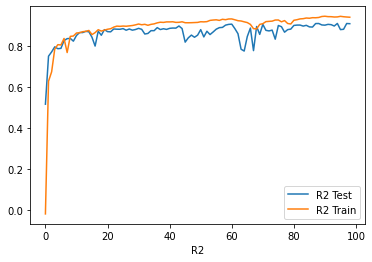

In [22]:
plt.plot(R2_test_2[1:],label ="R2 Test")
plt.plot(R2_train_2[1:],label="R2 Train")
plt.xlabel('Epoch')
plt.xlabel('R2')
plt.legend()

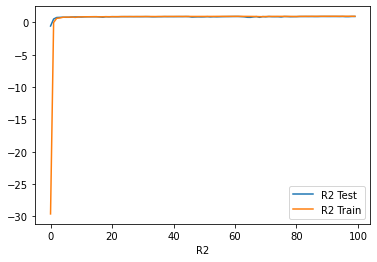

In [23]:
plt.plot(R2_test_2,label ="R2 Test")
plt.plot(R2_train_2,label="R2 Train")
plt.xlabel('Epoch')
plt.xlabel('R2')
plt.legend()

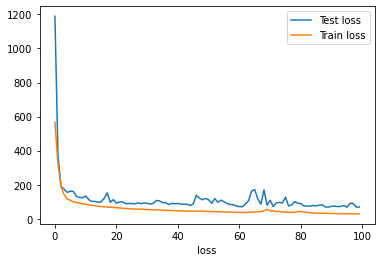

In [24]:
plt.plot(test_loss_2,label ="Test loss")
plt.plot(train_loss_2,label="Train loss")
plt.xlabel('Epoch')
plt.xlabel('loss')
plt.legend()

# Part C

In [39]:
def predict():
    
    input_dim = (3,64,64)
    model2 = CNN(3,1,input_dim)
    model2.load_state_dict(torch.load('model//NetA.pt'))
    model2.eval()
    
    source_folder = "//home//pc19d//hw8"
    dataset_train = MyDataset(folder=source_folder,train=True)
    dataset_val   = MyDataset(folder=source_folder,train=False)
    loader_train  = DataLoader(dataset=dataset_train, batch_size = 512)
    loader_test   = DataLoader(dataset=dataset_val,batch_size = 512)
    
    
    predictions_train, actuals_train = list(), list()
    with torch.no_grad():
        for data,label in loader_train:
            data = Variable(data)     
            y_predicted_train_batch = model2(data)
            actual = label.cpu().numpy() #In case if there's shuffling of data
            actual = actual.reshape((len(actual), 1))
            # store
           
            for element in y_predicted_train_batch:
                predictions_train.append(element)
            for element in actual:
                actuals_train.append(element)
    
    
    predictions_test, actuals_test = list(), list()    
    with torch.no_grad():
        for inputs, labels in loader_test:
            
            y_predicted_on_current_batch = model2(inputs)
            actual = labels.cpu().numpy() #In case if there's shuffling of data
            actual = actual.reshape((len(actual), 1))
            # store
            for element in y_predicted_on_current_batch:
                predictions_test.append(element)
            for element in actual:
                actuals_test.append(element)
    

    return predictions_train, actuals_train, predictions_test, actuals_test

In [40]:
predictions_train, actuals_train, predictions_test, actuals_test = predict()

In [52]:
residual_train = np.array(actuals_train) - np.array(predictions_train).reshape(-1,1)
residual_test  = np.array(actuals_test)  - np.array(predictions_test).reshape(-1,1)
print(residual_train.shape,residual_test.shape)

(18059, 1) (2261, 1)


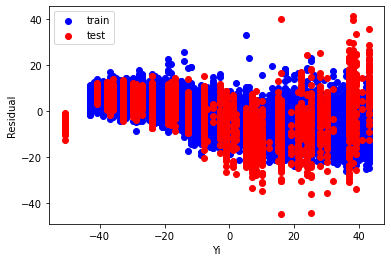

In [55]:
plt.scatter(actuals_train,residual_train,color="Blue",label="train")
plt.scatter(actuals_test,residual_test,color="red",label="test")
plt.xlabel("Yi")
plt.ylabel("Residual")
plt.legend()
plt.show()

# Part D

In [56]:
input_dim = (3,64,64)
model3 = CNN(3,1,input_dim)
model3.load_state_dict(torch.load('model//NetA.pt'))
num_param =  sum(p.numel() for p in model3.parameters())
num_param

51125

In [2]:
import pandas as pd

In [5]:
num_param = 51125
results = {}
results['Layer 1'] = ['Conv2d', 32, 5, 1, 2 ]
results['Layer 2'] = ['Conv2d + Batch_Normilization + RELU', 32, 5, 1, 2]
results['Layer 3'] = ['Conv2d + 2x2 max pooling + Batch_Normilization + RELU', 16, 5, 1, 2]
results['Layer 4'] = ['Conv2d + 2x2 max pooling + Batch_Normilization + RELU', 8, 2, 1, 2]
results['Layer 5'] = ['Linear', "_/10",'','','']
results['Layer 6'] = ['Linear', "10/1",'','','']
results['Total Number of Parameters'] = [num_param, '','','','' ]
pd.DataFrame(results, index = ['Layer Description' , 'Number of Filters(For Conv)/Number_of_Neuron(in/out)(For linear)', 'Kernel_Size','Pading','Dilation']).transpose()

,Layer Description,Number of Filters(For Conv)/Number_of_Neuron(in/out)(For linear),Kernel_Size,Pading,Dilation
Layer 1,Conv2d,32,5,1,2
Layer 2,Conv2d + Batch_Normilization + RELU,32,5,1,2
Layer 3,Conv2d + 2x2 max pooling + Batch_Normilization...,16,5,1,2
Layer 4,Conv2d + 2x2 max pooling + Batch_Normilization...,8,2,1,2
Layer 5,Linear,_/10,,,
Layer 6,Linear,10/1,,,
Total Number of Parameters,51125,,,,
